# Notebook for Research Project - Text and Multimedia Mining 2021/2022
---
# Steffan Borgers

Imports and Downloads

In [1]:
import zipfile, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
import wordcloud

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Reading the input csv

In [3]:
output = '/content/drive/MyDrive/Radboud Universiteit/Text and Multimedia Mining/Project/archive.zip'
with zipfile.ZipFile(os.path.abspath(output), 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('booking')

In [4]:
frame = pd.read_csv('/content/booking/Hotel_Reviews.csv')
#frame.head()
#frame.info()

Statistics and info about the dataset

In [5]:
frame['Average_Score'].describe()

count    515738.000000
mean          8.397487
std           0.548048
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: Average_Score, dtype: float64

In [6]:
frame['Hotel_Address'].nunique()

1493

In [7]:
frame.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [8]:
def freq_words(text, top_n_words = 25):
  words = (' '.join([word for word in text])).split()
  counts = dict(Counter(words).most_common(top_n_words))

  labels, values = zip(*counts.items())

  # sort your values in descending order
  indSort = np.argsort(values)[::-1]

  # rearrange your data
  labels = np.array(labels)[indSort]
  values = np.array(values)[indSort]

  indexes = np.arange(len(labels))

  bar_width = 0.35
  plt.figure(figsize=(25,5))
  plt.bar(indexes, values)

  # add labels
  plt.xticks(indexes + bar_width, labels)
  plt.show()

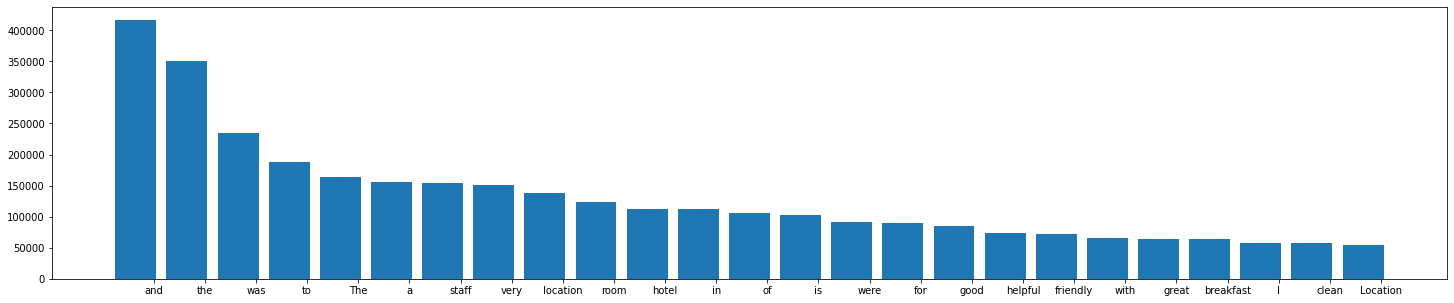

In [9]:
freq_words(frame['Positive_Review'])

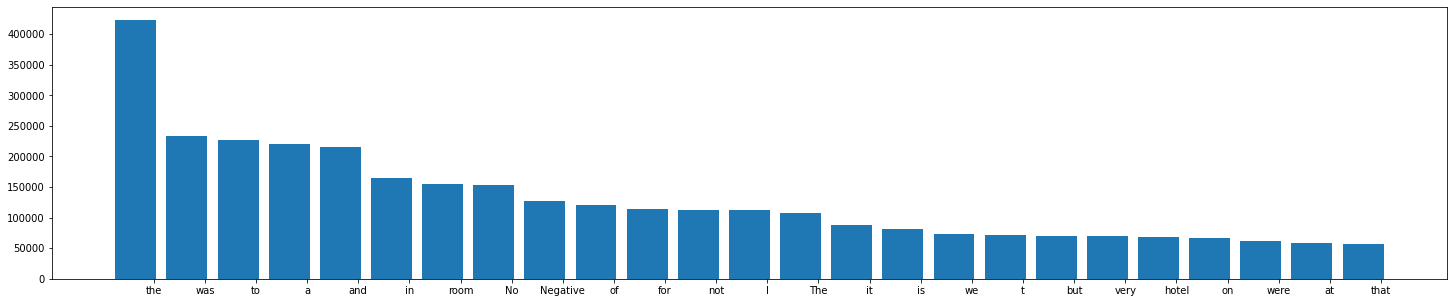

In [10]:
freq_words(frame['Negative_Review'])

Preprocessing


In [11]:
# Split the country into a separate column
frame['Country'] = frame.Hotel_Address.apply(lambda x: x.split(' ')[-1])
frame['Country'] = [x if x != 'Kingdom' else 'UK' for x in frame['Country']]

In [12]:
# Leave out reviews where no positive or no negative review is entered
frame = frame[frame['Review_Total_Positive_Word_Counts'] > 0]
frame = frame[frame['Review_Total_Negative_Word_Counts'] > 0]

Comparing Winter to Summer

In [13]:
def getmonth(date):
  return int(date.split('/')[0])
def getday(date):
  return int(date.split('/')[1])

def isSummer(date):
  day = getday(date)
  month = getmonth(date)
  return (day >= 15 and month >= 4 and month < 10) or (day < 15 and month > 4 and month <= 10)

def isWinter(date):
  return not isSummer(date)

def isRealSummer(date):
  return getmonth(date) in (6,7,8)

def isRealWinter(date):
  return getmonth(date) in (12,1,2)

def getAvgAndStd(frame):
  return "Mean: " + str(round(frame.mean(), 2)) + "\t Std: " + str(round(frame.std(),2)) + "\t Count: " + str(len(frame))

In [14]:
#frame['Review_Date'].head()
frame['Is_Summer'] = frame['Review_Date'].map(isSummer)
frame['Is_Winter'] = frame['Review_Date'].map(isWinter)
frame['Is_Real_Summer'] = frame['Review_Date'].map(isRealSummer)
frame['Is_Real_Winter'] = frame['Review_Date'].map(isRealWinter)
#frame['Is_Summer'].describe()

In [15]:
newframe = frame[['Reviewer_Score', 'Review_Date', 'Is_Summer', 'Is_Winter', 'Is_Real_Summer', 'Is_Real_Winter']]
summer = newframe[newframe['Is_Summer']]
winter = newframe[newframe['Is_Winter']]
realsummer = newframe[newframe['Is_Real_Summer']]
realwinter = newframe[newframe['Is_Real_Winter']]

In [16]:
print("Summer: " + getAvgAndStd(summer['Reviewer_Score']))
print("Winter: " + getAvgAndStd(winter['Reviewer_Score']))
print("Real Summer: " + getAvgAndStd(realsummer['Reviewer_Score']))
print("Real Winter: " + getAvgAndStd(realwinter['Reviewer_Score']))

Summer: Mean: 8.18	 Std: 1.64	 Count: 188964
Winter: Mean: 8.24	 Std: 1.6	 Count: 163065
Real Summer: Mean: 8.21	 Std: 1.64	 Count: 98173
Real Winter: Mean: 8.27	 Std: 1.6	 Count: 80721


Now looking at the countries individually

In [17]:
frame[['Country', 'Reviewer_Score']].groupby(['Country']).describe()

Reviewer_Score                                              
                     count      mean       std  min  25%  50%  75%   max
Country                                                                 
Austria            25533.0  8.343575  1.511369  2.5  7.5  8.8  9.6  10.0
France             39517.0  8.199656  1.656413  2.5  7.5  8.8  9.6  10.0
Italy              24695.0  8.144236  1.627468  2.5  7.1  8.3  9.6  10.0
Netherlands        39138.0  8.268243  1.587990  2.5  7.5  8.8  9.6  10.0
Spain              40634.0  8.359209  1.556836  2.5  7.5  8.8  9.6  10.0
UK                182512.0  8.149686  1.653389  2.5  7.1  8.3  9.6  10.0

In [18]:
def printStatsForCountry(frame, country):
  thiscountry = frame[frame['Country'] == country]
  print("Country: " + country)
  print("General: " + getAvgAndStd(thiscountry['Reviewer_Score']))
  print("Summer: " + getAvgAndStd(thiscountry[thiscountry['Is_Summer']]['Reviewer_Score']))
  print("Winter: " + getAvgAndStd(thiscountry[thiscountry['Is_Winter']]['Reviewer_Score']))
  print("Real Summer: " + getAvgAndStd(thiscountry[thiscountry['Is_Real_Summer']]['Reviewer_Score']))
  print("Real Winter: " + getAvgAndStd(thiscountry[thiscountry['Is_Real_Winter']]['Reviewer_Score']))

def calcSummerWinter(frame):
  frame['Is_Summer'] = frame['Review_Date'].map(isSummer)
  frame['Is_Winter'] = frame['Review_Date'].map(isWinter)
  frame['Is_Real_Summer'] = frame['Review_Date'].map(isRealSummer)
  frame['Is_Real_Winter'] = frame['Review_Date'].map(isRealWinter)
  return frame

In [19]:
countrydf = frame.loc[:,('Country', 'Reviewer_Score', 'Review_Date')]
countries = frame['Country'].unique()

countrydf = calcSummerWinter(countrydf)

for country in countries:
  printStatsForCountry(countrydf, country)

Country: Netherlands
General: Mean: 8.27	 Std: 1.59	 Count: 39138
Summer: Mean: 8.24	 Std: 1.6	 Count: 20594
Winter: Mean: 8.3	 Std: 1.58	 Count: 18544
Real Summer: Mean: 8.27	 Std: 1.6	 Count: 10991
Real Winter: Mean: 8.37	 Std: 1.55	 Count: 9096
Country: UK
General: Mean: 8.15	 Std: 1.65	 Count: 182512
Summer: Mean: 8.12	 Std: 1.67	 Count: 91983
Winter: Mean: 8.18	 Std: 1.63	 Count: 90529
Real Summer: Mean: 8.13	 Std: 1.67	 Count: 47028
Real Winter: Mean: 8.2	 Std: 1.63	 Count: 46237
Country: France
General: Mean: 8.2	 Std: 1.66	 Count: 39517
Summer: Mean: 8.16	 Std: 1.69	 Count: 22855
Winter: Mean: 8.25	 Std: 1.61	 Count: 16662
Real Summer: Mean: 8.2	 Std: 1.69	 Count: 11798
Real Winter: Mean: 8.29	 Std: 1.61	 Count: 7804
Country: Spain
General: Mean: 8.36	 Std: 1.56	 Count: 40634
Summer: Mean: 8.31	 Std: 1.58	 Count: 24376
Winter: Mean: 8.44	 Std: 1.51	 Count: 16258
Real Summer: Mean: 8.34	 Std: 1.58	 Count: 12919
Real Winter: Mean: 8.52	 Std: 1.49	 Count: 7148
Country: Italy
Gener

Determining what people are most appreciate of

In [20]:
# Remove stop words
stop_words = stopwords.words('english')
def remove_stopwords(review_text):
  review = review_text.split()
  return " ".join([word for word in review if word not in stop_words])

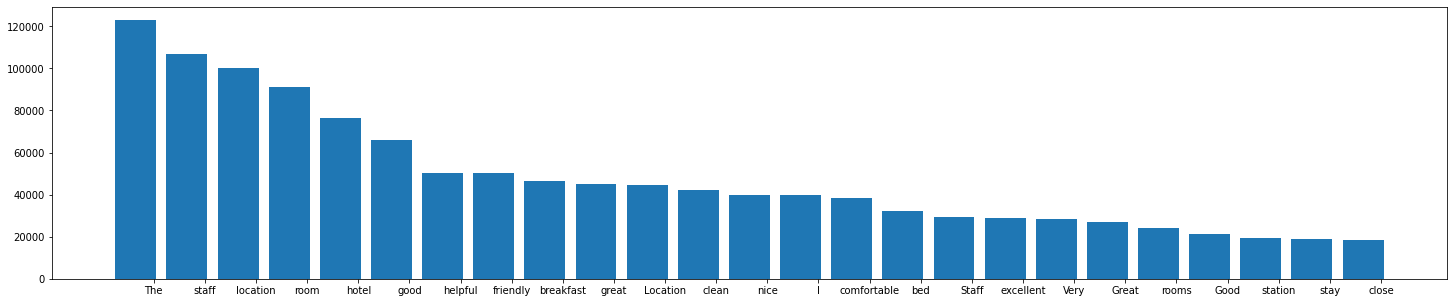

In [21]:
positive_clean = [remove_stopwords(review) for review in frame['Positive_Review']]
freq_words(positive_clean)

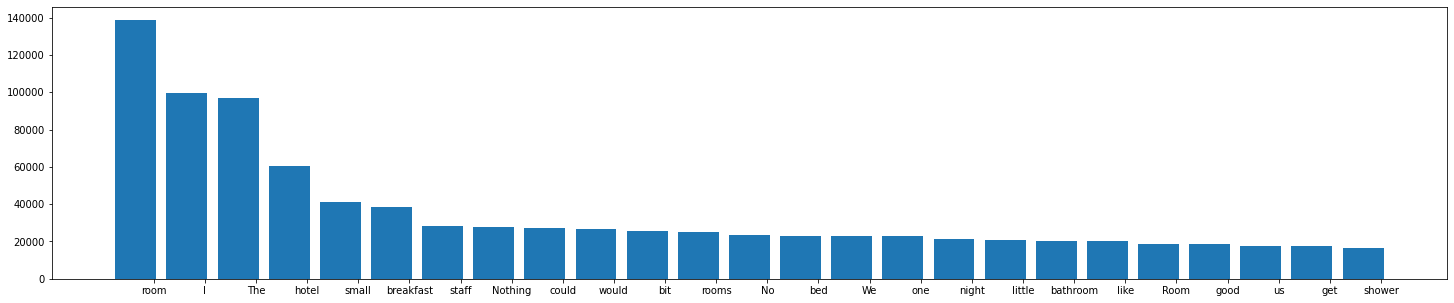

In [53]:
negative_clean = [remove_stopwords(review) for review in frame['Negative_Review']]
freq_words(negative_clean)

In [54]:
def rmv(list, val):
   return [value for value in list if value != val]

def cleanAndConcat(list):
  allreviews = ""
  for i in range(len(list)):
    allreviews += list[i]

  reviewList = allreviews.lower().split(' ')
  reviewList = rmv(reviewList, '')
  reviewList = rmv(reviewList, 'very')
  reviewList = [x if x not in ('was','were') else 'is' for x in reviewList]
  return reviewList

def printMostCommonN(list, n= 1):
  ngramfrequencies = nltk.FreqDist(nltk.ngrams(list, n))
  freqs = ngramfrequencies.most_common(25)
  for freq in freqs:
    print(" ".join(freq[0]) + ',')

In [26]:
positive_concat = cleanAndConcat(positive_clean)

In [55]:
negative_concat = cleanAndConcat(negative_clean)

In [ ]:
printMostCommonN(positive_concat, 1)

In [ ]:
printMostCommonN(positive_concat, 2)

In [ ]:
printMostCommonN(positive_concat, 3)

In [ ]:
printMostCommonN(positive_concat, 4)

In [56]:
printMostCommonN(negative_concat, 1)

room,
i,
hotel,
the,
breakfast,
small,
staff,
would,
could,
bit,
one,
rooms,
bed,
little,
bathroom,
like,
night,
get,
us,
shower,
we,
also,
good,
bar,
service,


In [57]:
printMostCommonN(negative_concat, 2)

i would,
room small,
room service,
the room,
air conditioning,
room i,
booking com,
tea coffee,
star hotel,
4 star,
i could,
even though,
i think,
i asked,
little bit,
small room,
the hotel,
front desk,
air con,
double bed,
could hear,
mini bar,
hotel i,
i booked,
would nice,


In [58]:
printMostCommonN(negative_concat, 3)

4 star hotel,
tea coffee making,
coffee making facilities,
5 star hotel,
tea coffee facilities,
two single beds,
even though i,
making facilities room,
room bit small,
beds pushed together,
i could hear,
room quite small,
the room small,
i would expect,
tea making facilities,
front desk staff,
four star hotel,
i would recommend,
room little small,
4 stars hotel,
2 single beds,
could hear people,
single beds pushed,
i told i,
room next door,


In [59]:
printMostCommonN(negative_concat, 4)

tea coffee making facilities,
coffee making facilities room,
single beds pushed together,
tea coffee facilities room,
two single beds pushed,
two singles pushed together,
tea making facilities room,
4 star hotel i,
2 single beds pushed,
coffee tea making facilities,
bit far city center,
room two single beds,
4 star hotel the,
i booked booking com,
no tea coffee making,
tea coffee making facility,
i would recommend hotel,
room i ever stayed,
bed two single beds,
per person per day,
breakfast included room rate,
double bed two single,
bed two singles pushed,
twin beds pushed together,
single beds put together,


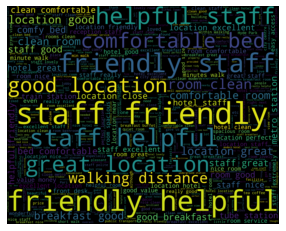

In [ ]:
wordcloud = wordcloud.WordCloud(width=2500,
                      height=2000,
                      max_words=500).generate(allreviews)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

VALIDATION - Are all positive reviews really positive?

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sid = SentimentIntensityAnalyzer()

def isValidSentiment(review, positive = True):
  score = sid.polarity_scores(review)
  if positive:
    return score['neg'] <= score['neu']
  else:
    return score['pos'] <= score['neu']

In [ ]:
frame['Positive_Sent'] = frame['Positive_Review'].apply(lambda x: isValidSentiment(x, True))

In [ ]:
print(len([x for x in frame['Positive_Sent'] if not x]))

negFrame = frame[frame['Positive_Sent'] == False]
len(negFrame)


739


739

In [ ]:
frame['Negative_Sent'] = frame['Negative_Review'].apply(lambda x: isValidSentiment(x, False))

In [ ]:
print(len([x for x in frame['Negative_Sent'] if not x]))

sentCheck = frame[frame['Negative_Sent'] == False]
len(sentCheck)


7852


7852